In [1]:
# Class Definition & Setup

from types import SimpleNamespace
import numpy as np
import matplotlib.pyplot as plt

class ExchangeEconomyModelClass:

    def __init__(self):

        par = self.par = SimpleNamespace()

        # Preferences
        par.alpha_A = 1.0
        par.beta_A = (12/37)**3
        par.rho_A = -2.0

        par.alpha_B = (12/37)**3
        par.beta_B = 1.0
        par.rho_B = -2.0

        # Endowments
        par.w1A = 1.0 - 1e-8
        par.w2A = 1e-8

        # Algorithm parameters
        par.tol = 1e-8
        par.K = 5000
        par.nu = 50.0
        par.varphi = 0.1
        par.iota = 0.99



    # Preferences and Demand

    def CES_utility(self,x1,x2,alpha,beta,rho):
        return (alpha*x1**rho + beta*x2**rho)**(1/rho)

    def CES_indifference(self,u,x1,alpha,beta,rho):
        x2 = np.nan*np.ones_like(x1)
        temp = (u**rho - alpha*x1**rho)/beta
        I = temp >= 0
        x2[I] = temp[I]**(1/rho)
        return x2

    def CES_demand(self,p1,m,alpha,beta,rho):
        sigma = 1/(1-rho)
        fac1 = alpha**sigma * p1**(1-sigma)
        fac2 = beta**sigma
        denom = fac1 + fac2
        x1 = fac1/p1 * m/denom
        x2 = fac2 * m/denom
        return x1,x2

    def demand_A(self,p1):
        m = p1*self.par.w1A + self.par.w2A
        return self.CES_demand(p1,m,
                               self.par.alpha_A,
                               self.par.beta_A,
                               self.par.rho_A)

    def demand_B(self,p1):
        m = p1*(1-self.par.w1A) + (1-self.par.w2A)
        return self.CES_demand(p1,m,
                               self.par.alpha_B,
                               self.par.beta_B,
                               self.par.rho_B)



    # Excess demand 

    def excess_demand_1(self,p1):
        x1A,_ = self.demand_A(p1)
        x1B,_ = self.demand_B(p1)
        return x1A + x1B - 1.0



    # Walras algorithms 

    def solve_walras(self,p0,method='tatonnement'):

        p = p0
        p_path = []
        eps_path = []

        for _ in range(self.par.K):

            eps = self.excess_demand_1(p)
            p_path.append(p)
            eps_path.append(eps)

            if abs(eps) < self.par.tol:
                return p, np.array(p_path), np.array(eps_path)

            if method == 'tatonnement':
                p = p + self.par.nu*eps
                # Safety for Tatonnement
                if p <= 0: p = 1e-8

            elif method == 'newton':
                h = 1e-6
                # Numeric derivative
                eps_h = self.excess_demand_1(p+h)
                delta = (eps_h - eps)/h
                
                if delta == 0: break 
                
                # Update
                p_new = p - self.par.varphi*eps/delta
                
                # Check for negative price before assigning
                if p_new < 0:
                    p = self.par.iota * p 
                else:
                    p = p_new

        return p, np.array(p_path), np.array(eps_path)



    # Utilities

    def utility_A(self, x1A, x2A):
        return self.CES_utility(
            x1A, x2A,
            self.par.alpha_A,
            self.par.beta_A,
            self.par.rho_A
        )

    def utility_B(self, x1B, x2B):
        return self.CES_utility(
            x1B, x2B,
            self.par.alpha_B,
            self.par.beta_B,
            self.par.rho_B
        )

    def x2A_indifference(self, uA, x1A):
        return self.CES_indifference(
            uA, x1A,
            self.par.alpha_A,
            self.par.beta_A,
            self.par.rho_A
        )

    def x2B_indifference(self, uB, x1B):
        return self.CES_indifference(
            uB, x1B,
            self.par.alpha_B,
            self.par.beta_B,
            self.par.rho_B
        )

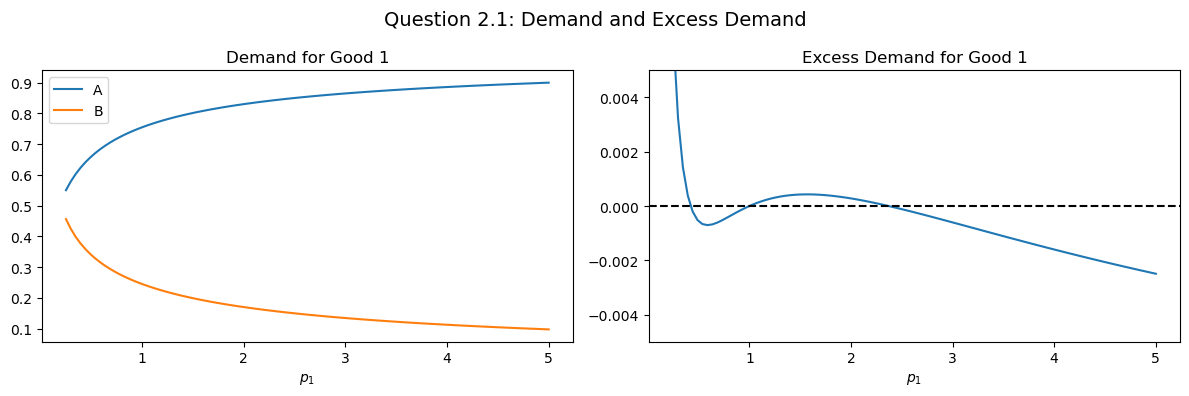

In [2]:
# Question 2.1 - Plotting Demand and Excess Demand

model = ExchangeEconomyModelClass()

# 1. Price grid
p_grid = np.linspace(0.25, 5, 100)

# 2. Containers
x1A = np.zeros_like(p_grid)
x1B = np.zeros_like(p_grid)
eps1 = np.zeros_like(p_grid)

# 3. Compute Demand and Excess Demand
for i, p1 in enumerate(p_grid):
    x1A[i], _ = model.demand_A(p1)
    x1B[i], _ = model.demand_B(p1)
    eps1[i] = model.excess_demand_1(p1)

# 4. Plots
fig, ax = plt.subplots(1, 2, figsize=(12,4))

ax[0].plot(p_grid, x1A, label='A')
ax[0].plot(p_grid, x1B, label='B')
ax[0].set_title('Demand for Good 1')
ax[0].set_xlabel('$p_1$')
ax[0].legend()

ax[1].plot(p_grid, eps1)
ax[1].axhline(0, color='black', ls='--')
ax[1].set_title('Excess Demand for Good 1')
ax[1].set_xlabel('$p_1$')
ax[1].set_ylim(-0.005, 0.005)

fig.suptitle('Question 2.1: Demand and Excess Demand', fontsize=14)
plt.tight_layout()
plt.show()

As it is seen in the right figure "Excess demand for good 1", there are 3 different equilibria. These occur when the curve which illustrates excess demand for good 1, is equal to 0. This happens at: $p_1\approx 0,5$, $p_1\approx 1$ and $p_1\approx 2,4$

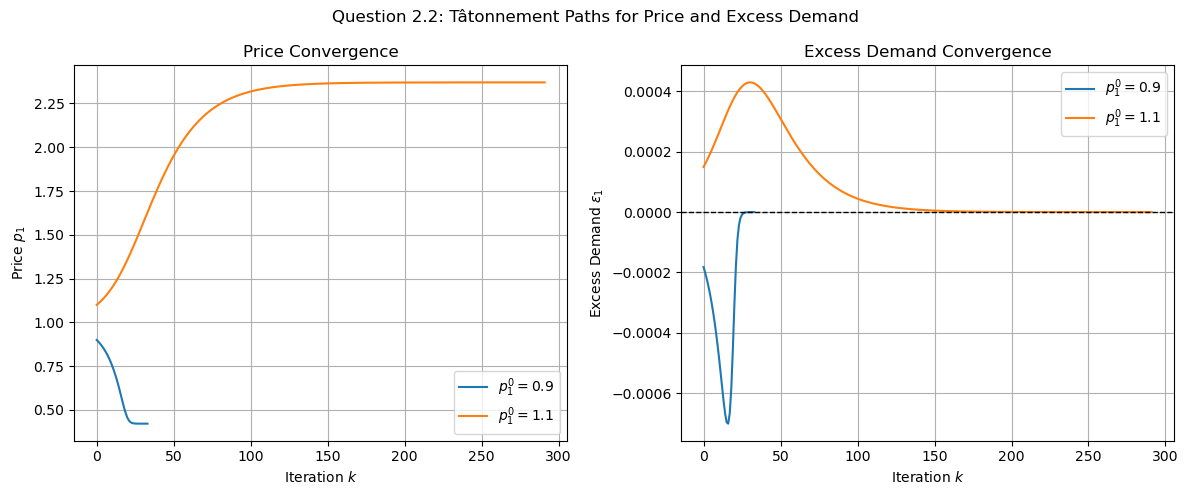

In [3]:
# Question 2.2 - Tâtonnement Algorithm

# Compute Tatonnement paths
p_star_09, p_path1, eps_path1 = model.solve_walras(0.9, method='tatonnement')
p_star_11, p_path2, eps_path2 = model.solve_walras(1.1, method='tatonnement')

# Create a figure with 2 subplots side-by-side
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Price Paths
ax[0].plot(p_path1, label='$p_1^0 = 0.9$')
ax[0].plot(p_path2, label='$p_1^0 = 1.1$')
ax[0].set_xlabel('Iteration $k$')
ax[0].set_ylabel('Price $p_1$')
ax[0].set_title('Price Convergence')
ax[0].legend()
ax[0].grid(True)

# Plot 2: Excess Demand Paths 
ax[1].plot(eps_path1, label='$p_1^0 = 0.9$')
ax[1].plot(eps_path2, label='$p_1^0 = 1.1$')
ax[1].set_xlabel('Iteration $k$')
ax[1].set_ylabel('Excess Demand $\epsilon_1$')
ax[1].set_title('Excess Demand Convergence')
ax[1].axhline(0, color='black', linestyle='--', linewidth=1) 
ax[1].legend()
ax[1].grid(True)

fig.suptitle('Question 2.2: Tâtonnement Paths for Price and Excess Demand')
plt.tight_layout()
plt.show()

Yes, the choice of initial guess determines which equilibrium is found.
The economy is bistable. Initial guesses below the unstable threshold $(p_1\approx 1)$ converge to the low equilibrium, while guesses above it converge to the high equilibrium

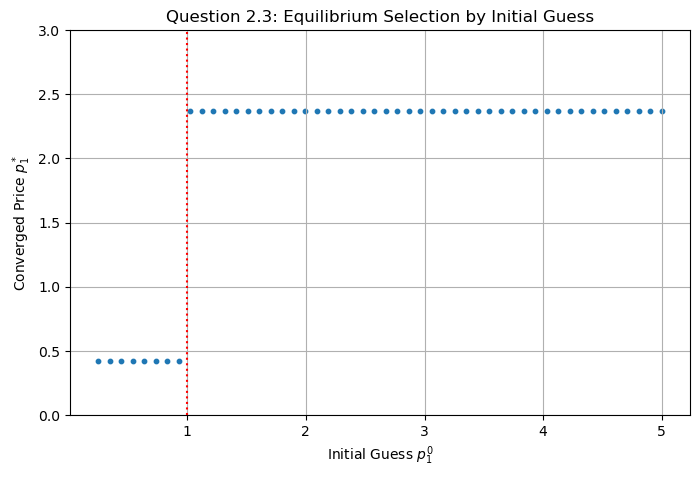

This plot reveals that the economy is bistable. It demonstrates that the
final outcome depends entirely on the starting point: initial prices below ≈1.0
fall to the low equilibrium, while prices above rise to the high equilibrium.


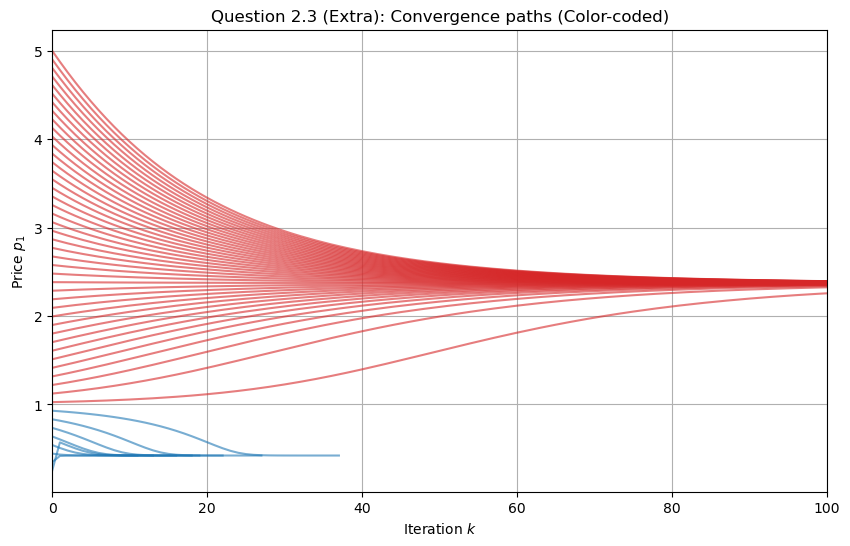

This plot visualizes the market forces in action. It shows how the unstable equilibrium
at p₁ ≈ 1.0 acts as a repeller, pushing prices away slowly at first before
they accelerate toward the stable equilibria.


In [4]:
# Question 2.3 - Multiple Equilibria Check

# Setup
p0_grid = np.linspace(0.25, 5, 50)
results_p_star = []
results_paths = []

# Run Simulations
for p0 in p0_grid:
    p_star, p_path, _ = model.solve_walras(p0, method='tatonnement')
    results_p_star.append(p_star)
    results_paths.append(p_path)

# Figure 1: Initial guess vs. Final equilibrium 
plt.figure(figsize=(8, 5))
plt.scatter(p0_grid, results_p_star, s=10)
plt.xlabel('Initial Guess $p_1^0$')
plt.ylabel('Converged Price $p_1^*$')
plt.axvline(1.0, color='red', linestyle=':', label='Unstable Equilibrium ($p_1 \\approx 1.0$)') #Vertical line at unstable equilibrium
plt.ylim(0, 3)
plt.title('Question 2.3: Equilibrium Selection by Initial Guess')
plt.grid(True)
plt.show()
print("This plot reveals that the economy is bistable. It demonstrates that the")
print("final outcome depends entirely on the starting point: initial prices below ≈1.0")
print("fall to the low equilibrium, while prices above rise to the high equilibrium.")

# Figure 2: Extra: Convergence Paths 
plt.figure(figsize=(10, 6))

# Loop through paths and their final results simultaneously
for path, p_end in zip(results_paths, results_p_star):
    
    if p_end < 1.0:
        col = 'tab:blue'  # Blue for low equilibrium
    else:
        col = 'tab:red'   # Red for high equilibrium
        
    plt.plot(path, color=col, alpha=0.6) 

plt.xlabel('Iteration $k$')
plt.ylabel('Price $p_1$')
plt.title('Question 2.3 (Extra): Convergence paths (Color-coded)')
plt.grid(True)
plt.xlim(0, 100)
plt.show()
print("This plot visualizes the market forces in action. It shows how the unstable equilibrium")
print("at p₁ ≈ 1.0 acts as a repeller, pushing prices away slowly at first before")
print("they accelerate toward the stable equilibria.")


No, we do not find all equilibria.
We only find the two stable equilibria, plotted in the first figure above

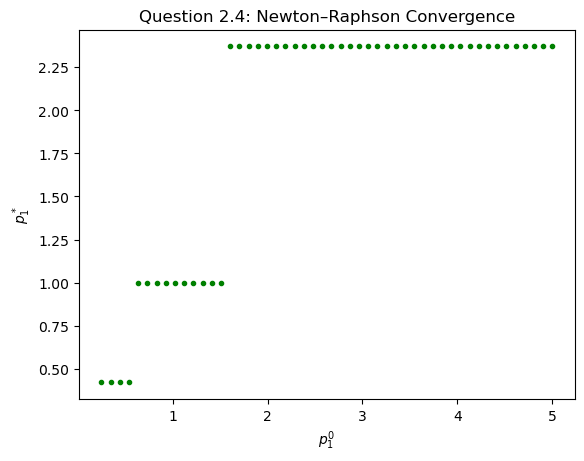

In [5]:
# Question 2.4 - Newton-Raphson Algorithm

# Grid of initial prices
p0_grid = np.linspace(0.25, 5, 50)

# Store resulting equilibrium prices (Newton)
p_star_newton = np.zeros_like(p0_grid)

for i, p0 in enumerate(p0_grid):
    p_star_newton[i], _, _ = model.solve_walras(p0, method='newton')

plt.figure()
plt.plot(p0_grid, p_star_newton, '.', color='green')
plt.xlabel('$p_1^0$')
plt.ylabel('$p_1^*$')
plt.title('Question 2.4: Newton–Raphson Convergence')
plt.show()

Under tâtonnement, the algorithm converges only to the stable low- and high-price equilibria, while the intermediate equilibrium is not found because it is unstable. In contrast, the dampened Newton–Raphson algorithm converges to all equilibria, including the intermediate one, since it uses local slope information and is not restricted to stable equilibria.

Found Equilibria:
  p1 ≈ 0.42
  p1 ≈ 1.00
  p1 ≈ 2.37


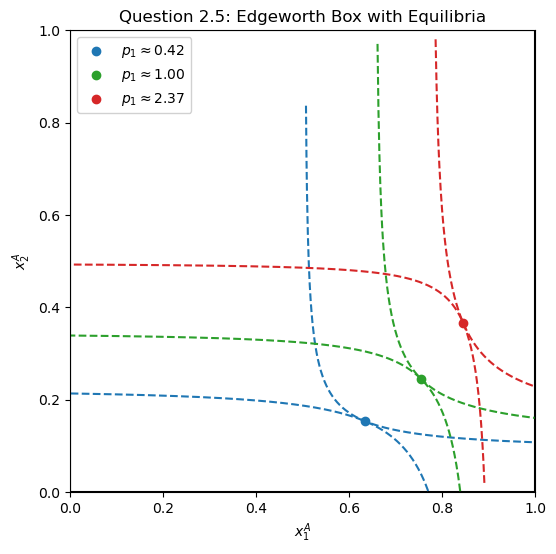

In [6]:
# Question 2.5 - Edgeworth Box

# Identify unique equilibria from results (Round to avoid minor float diffs)
unique_equilibria = np.unique(np.round(p_star_newton, 2))

# Text output
print("Found Equilibria:")
for p in unique_equilibria:
    print(f"  p1 ≈ {p:.2f}")

# Create Edgeworth box
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)

# Box limits
ax.plot([0,1],[0,0],'k')
ax.plot([0,1],[1,1],'k')
ax.plot([0,0],[0,1],'k')
ax.plot([1,1],[0,1],'k')

ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_xlabel('$x_1^A$')
ax.set_ylabel('$x_2^A$')

colors = ['tab:blue', 'tab:green', 'tab:red']

for i, p1 in enumerate(unique_equilibria):
    
    col = colors[i % 3]
    
    # Equilibrium allocations
    x1A, x2A = model.demand_A(p1)
    x1B, x2B = model.demand_B(p1)

    # Equilibrium point
    ax.scatter(x1A, x2A, color=col, label=f'$p_1 \\approx {p1:.2f}$', zorder=5)

    # A: Indifference curve
    uA = model.utility_A(x1A, x2A)
    x1 = np.linspace(0.001, 0.999, 1000)
    x2A_curve = model.x2A_indifference(uA, x1)
    I = (x2A_curve > 0) & (x2A_curve < 1)
    ax.plot(x1[I], x2A_curve[I], '--', color=col, alpha=1)

    # B: Indifference curve (mirrored)
    uB = model.utility_B(x1B, x2B)
    x2B_curve = model.x2B_indifference(uB, x1)
    I = (x2B_curve > 0) & (x2B_curve < 1)
    # B's origin is top-right (1,1), so we subtract from 1
    ax.plot(1 - x1[I], 1 - x2B_curve[I], '--', color=col, alpha=1)

ax.set_title('Question 2.5: Edgeworth Box with Equilibria')
ax.legend(framealpha=0.9)
plt.show()